In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.decomposition import PCA

# Project Overview
It is a kaggle competition: https://www.kaggle.com/competitions/short-term-paper-4/overview

Our task is to use binary classification to predict a patient's smoking status given information about various other health indicators.

The dataset was generated from a deep learning model trained on https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

**train.csv**: traning dataset with the binary target *smoking*

**test.csv**: test dataset to predict the probability of positive *smoking*


## Data Loading

In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Path to CSV file in Google Drive
train_csv = '/content/drive/My Drive/Short Term Paper 4/train.csv'
test_csv = '/content/drive/My Drive/Short Term Paper 4/test.csv'

Mounted at /content/drive


In [ ]:
train_dt = pd.read_csv(train_csv)
train_dt.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,40.0,155.0,45.0,63.0,1.2,1.5,1.0,1.0,108.0,...,64.0,105.0,12.1,1.0,0.9,14.0,8.0,10.0,0.0,0.0
1,1,60.0,170.0,75.0,89.0,0.8,1.0,1.0,1.0,120.0,...,63.0,126.0,15.2,1.0,1.0,26.0,18.0,21.0,0.0,0.0
2,2,45.0,160.0,55.0,70.0,1.2,1.2,1.0,1.0,115.0,...,55.0,93.0,13.7,1.0,0.6,15.0,11.0,15.0,0.0,0.0
3,3,55.0,165.0,70.0,88.0,1.0,0.7,1.0,1.0,120.0,...,55.0,104.0,15.2,1.0,0.8,27.0,28.0,29.0,0.0,0.0
4,4,40.0,160.0,50.0,70.0,1.0,1.2,1.0,1.0,103.0,...,88.0,101.0,12.9,1.0,0.7,17.0,9.0,20.0,0.0,0.0


In [ ]:
train_dt['smoking'].unique()

array([0., 1.])

In [ ]:
test_dt = pd.read_csv(test_csv)
test_dt.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,45.0,155.0,55.0,76.0,0.6,0.7,1.0,1.0,111.0,...,76.0,61.0,117.0,13.5,1.0,0.9,17.0,11.0,14.0,0.0
1,15001,40.0,155.0,50.0,70.0,1.2,1.5,1.0,1.0,114.0,...,47.0,81.0,89.0,12.5,1.0,0.6,14.0,10.0,10.0,0.0
2,15002,35.0,170.0,70.0,81.0,1.0,1.0,1.0,1.0,124.0,...,84.0,48.0,128.0,15.7,1.0,0.6,14.0,18.0,15.0,0.0
3,15003,60.0,150.0,50.0,76.0,0.9,0.8,1.0,1.0,117.0,...,85.0,50.0,100.0,13.0,1.0,0.8,32.0,21.0,21.0,0.0
4,15004,40.0,160.0,50.0,68.0,1.2,1.2,1.0,1.0,103.0,...,93.0,64.0,103.0,12.8,1.0,0.6,19.0,13.0,9.0,0.0


In [ ]:
train_dt['smoking'][train_dt['smoking'] == 1].count()

5532

In [ ]:
sum(train_dt['smoking'][train_dt['smoking'] == 1])
train_dt['smoking'][train_dt['smoking'] == 0].count()

9468

In [ ]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

## EDA

We look up the training database to find missing and negative values, and we find that all values in this database are valid

In [ ]:
negative_values = train_dt.lt(0).any()
negative_values[negative_values].index.tolist()

[]

Then we draw the correlation heatmap upon all features, wondering which features are interrelated with each other. If some features are dependent on others, simply calculating the result with equal weight may cause a bias.

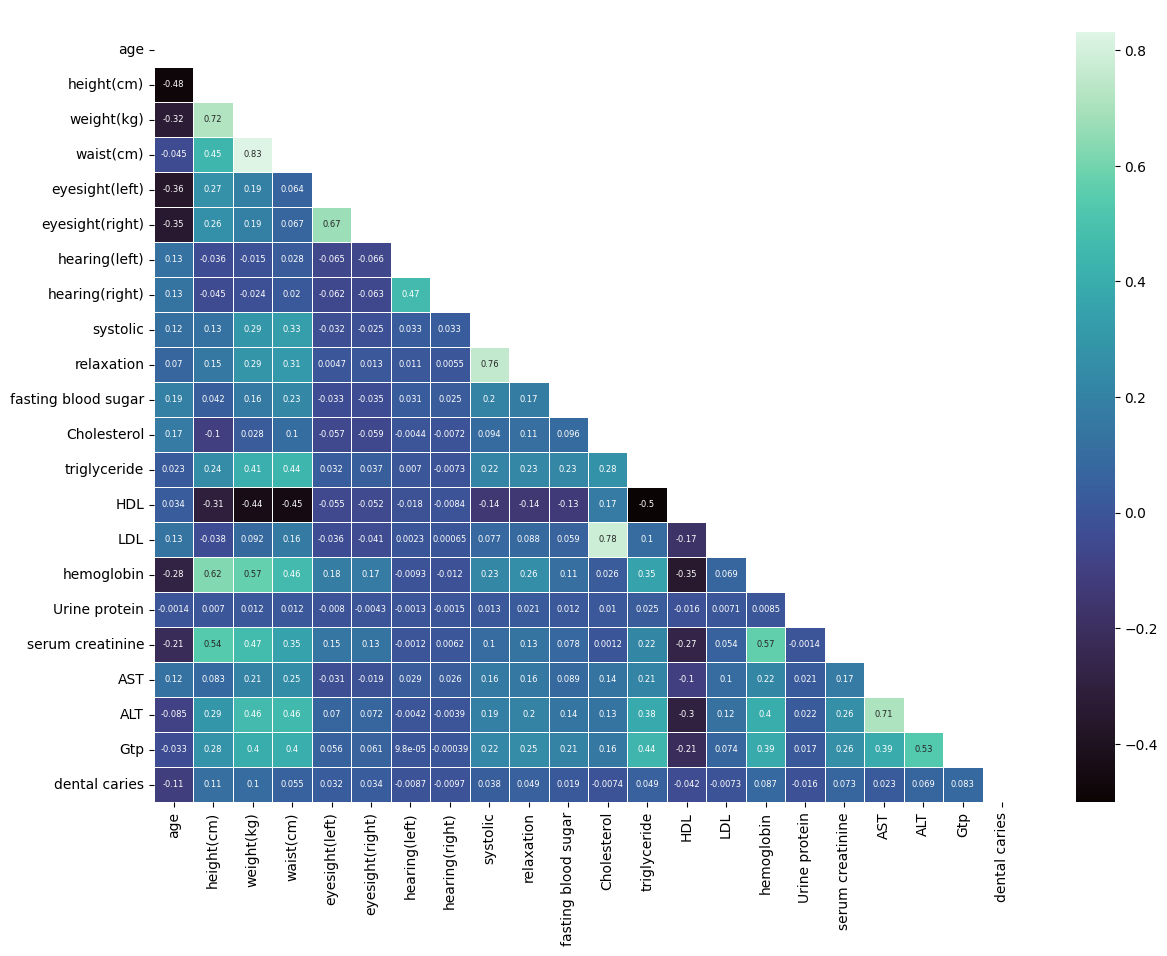

In [ ]:
X = train_dt.drop(columns=['id', 'smoking'])
y = train_dt['smoking']
test = test_dt.drop(columns=['id'])

df = X.copy()

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    excluded_columns = ['id']
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    corr = df[columns_without_excluded].corr()

    fig, axes = plt.subplots(figsize=(14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='mako', annot=True, annot_kws={"size": 6})
    plt.title(title_name, color='white')
    plt.show()

# Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df, 'Dataset Correlation')

## Feature Engineering

According to this heatmap, we noticed that height and weight are strongly correlated, which has a correlation index of 0.72. We considered finding a solution that minimizes the potential negative effect of this relationship. Introducing a common index called BMI, a measure of body fat based on height and weight, we inserted this new column to monitor obesity conditions and standardize the body fat of individuals. Then, we noticed that hearing and eyesight may contribute to the overfitting issue. When dealing with hearing and eyesight, one side may be significantly better than the other side, and in such circumstances, predicting the smoker according to these features is relatively meaningless. For hearing, we compared the left and right sides to categorize them into best and worst values. By decreasing one on best and worst, we got the normalized data and it would contribute to better model performance. In addition, we capped the eyesight values by treating values, which are greater than 9, as 0. Then, we categorized the best and worst of eyesight values. Several blood indices were clipped to valid ranges to ensure that they were medically reasonable. Triglyceride and Gtp could vary widely among individuals and were always right-skewed. We applied a log transformation to these features. By implementing various feature engineering, we successfully normalized the data, removed the potential outliers, and scaled down the range and magnitude.

In [ ]:
def create_extra_features(df):
  best = np.where(df['hearing(left)'] < df['hearing(right)'], df['hearing(left)'],  df['hearing(right)'])
  worst = np.where(df['hearing(left)'] < df['hearing(right)'], df['hearing(right)'],  df['hearing(left)'])
  df['hearing(left)'] = best - 1
  df['hearing(right)'] = worst - 1

  df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
  df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
  best = np.where(df['eyesight(left)'] < df['eyesight(right)'], df['eyesight(left)'],  df['eyesight(right)'])
  worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], df['eyesight(right)'],  df['eyesight(left)'])
  df['eyesight(left)'] = best
  df['eyesight(right)'] = worst

  df['Gtp'] = np.clip(df['Gtp'], 0, 300)
  df['HDL'] = np.clip(df['HDL'], 0, 110)
  df['LDL'] = np.clip(df['LDL'], 0, 200)
  df['ALT'] = np.clip(df['ALT'], 0, 150)
  df['AST'] = np.clip(df['AST'], 0, 100)
  df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)

  df['bmi'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2


  df['log_triglyceride'] = np.log1p(df['triglyceride'])
  df['log_gtp'] = np.log1p(df['Gtp'])

  return df

X = create_extra_features(X)
test = create_extra_features(test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Gtp,dental caries,bmi,log_triglyceride,log_gtp,age_<20,age_20-40,age_40-60,age_60-80,age_>80
0,40.0,155.0,45.0,63.0,1.2,1.5,0.0,0.0,108.0,66.0,...,10.0,0.0,18.730489,4.442651,2.397895,False,True,False,False,False
1,60.0,170.0,75.0,89.0,0.8,1.0,0.0,0.0,120.0,76.0,...,21.0,0.0,25.951557,4.574711,3.091042,False,False,True,False,False
2,45.0,160.0,55.0,70.0,1.2,1.2,0.0,0.0,115.0,62.0,...,15.0,0.0,21.484375,3.871201,2.772589,False,False,True,False,False
3,55.0,165.0,70.0,88.0,0.7,1.0,0.0,0.0,120.0,80.0,...,29.0,0.0,25.711662,4.465908,3.401197,False,False,True,False,False
4,40.0,160.0,50.0,70.0,1.0,1.2,0.0,0.0,103.0,64.0,...,20.0,0.0,19.531250,3.713572,3.044522,False,True,False,False,False


## Normalization (discard)

We used two ways to normalize the dataset. The first method was to implement the Standard Scaler, which calculated the normalized data by subtracting the data from the mean and dividing it by the standard deviation. The result was not good enough, so we tried the second method, MinMax Scaler, in which data was subtracted from the mean and divided by the difference of max and min. Since the MinMax Scaler would narrow down the range of the data, it was very sensitive to outliers. However, with similar modifications in feature engineering which gave better results, we did not apply MinMax normalization in the end.

In [ ]:
## V1.Normalize
d = preprocessing.normalize(X)
scaled_df = pd.DataFrame(d, columns=X.columns)
X_norm = pd.DataFrame(scaled_df, columns=X.columns)
X_norm.head()

X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.2, random_state=42)


In [ ]:
## V2.MinMax Scaler
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X)
X_minmax = pd.DataFrame(d, columns=X.columns)
X_minmax.head()

d2 = scaler.fit_transform(test)
test_minmax = pd.DataFrame(d2, columns=test.columns)
test_minmax.head()

X_train, X_val, y_train, y_val = train_test_split(X_minmax, y, test_size=0.2, random_state=42)

## XGB Boost


we tried XGBoost, a commonly used algorithm known for its robust performance in binary classification tasks with tabular data.

we initially observed signs of overfitting, which was evidenced by high accuracy on the training set but lower accuracy on the test set. To address this, we introduced the gamma parameter to control the minimum loss reduction required for a split.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 300, 600],         # Number of boosting rounds
    'max_depth': [4, 6, 8],                 # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'colsample_bytree': [0.3, 0.5, 0.7],    # Fraction of features used per tree
    'scale_pos_weight': [1, 2, 3]           # For handling class imbalance
}

# Define the XGBoost model
xgb_model = XGBClassifier(tree_method='hist', random_state=42)

# Define a scorer for GridSearchCV using ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=roc_auc_scorer,  # Use ROC AUC as the evaluation metric
    cv=3,                    # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                # Use all available cores for parallel processing
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

# Train the best model on the full training set
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Predict probabilities and actual classes on the validation set
y_pred_prob = best_xgb_model.predict_proba(X_val)[:, 1]
y_pred = best_xgb_model.predict(X_val)

# Evaluate model performance on the validation set
roc = roc_auc_score(y_val, y_pred_prob)
print("Validation ROC AUC Score:", roc)

In [ ]:
#scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = XGBClassifier(tree_method='hist',
                          n_estimators=250,
                          max_depth=6,
                          learning_rate=0.1,
                          colsample_bytree=0.5,
                          random_state=42,
                          gamma = 0.05,
                          )

xgb_model.fit(X_train, y_train)

# Predict probabilities and actual classes on the validation set
y_pred_prob = xgb_model.predict_proba(X_val)[:, 1]
y_pred = xgb_model.predict(X_val)

auc = metrics.roc_auc_score(y_val, y_pred_prob)
auc

0.8887588514906104

In [ ]:
test_probs = xgb_model.predict_proba(test)[:, 1]

output_df = pd.DataFrame({
    'id': test_dt['id'],
    'smoking': test_probs
})

output_file = 'submission.csv'
output_df.to_csv(output_file, index=False)

In [ ]:
output_df.head()

,id,smoking
0,15000,0.030715
1,15001,0.007140
2,15002,0.337929
3,15003,0.005700
4,15004,0.004235


In the training process, we also accounted for the challenges posed by the imbalanced dataset, as the non-smoking target was approximately twice as prevalent as the smoking target. To solve this issue, we tried to assign different class weights to adjust the model’s focus. However, it did not reflect a significant increase in the AUC score.

## Random Forest


we explored the random forest algorithm, which does not assume any underlying distribution of the data and is capable of handling feature collinearity implicitly.

To fine-tune its performance, we employed grid search for hyperparameter optimization.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [500, 1000, 2000],          # Number of trees
    'max_depth': [6, 10, 20, None],            # Maximum depth of trees
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features considered for splits
    'bootstrap': [True, False]                 # Whether to use bootstrapping
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define ROC AUC as the scoring metric
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=cv,
    verbose=2,   # Print progress
    n_jobs=-1    # Use all available cores
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

# Train the best model on the full training set
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predict probabilities on the validation set
val_fold_preds = best_rf_model.predict_proba(X_val)[:, 1]

# Calculate and print the AUC for the validation set
auc = roc_auc_score(y_val, val_fold_preds)
print("Validation ROC AUC Score:", auc)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': 400,  # Reduce the number of estimators
    'max_depth': 10,
    'min_samples_leaf': 4,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1  # Utilize all available processors
}


model = RandomForestClassifier(**params)
model.fit(X_train, y_train)
val_fold_preds = model.predict_proba(X_val)[:, 1]

# Calculate and print the AUC for this fold
auc = roc_auc_score(y_val, val_fold_preds)
auc

0.8803751376129716

In [ ]:
y_test_prob = model.predict_proba(test)[:, 1]
y_test_prob

array([0.02090367, 0.02837685, 0.34510263, ..., 0.63094948, 0.69436785,
       0.04371108])

In [ ]:
output_df = pd.DataFrame({
    'id': test_dt['id'],
    'smoking': y_test_prob
})

output_file = 'submission.csv'
output_df.to_csv(output_file, index=False)

Finally, we achieved a 0.8889 auc score with approximately 80% of the test data and 0.88073 with approximately 20% of the test data